In [2]:
!pip install pytorch-tabnet

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier


In [4]:

from google.colab import drive
drive.mount('/content/drive')

folder = '/content/drive/MyDrive/Colab Notebooks/ML study/day27 220126/test'

Mounted at /content/drive


In [6]:
train = pd.read_csv(os.path.join(folder,'census-income.data'), header=None)
target = 41    # 41번째 컬럼
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [7]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]



X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

0 91
1 9
2 52
3 47
4 17
6 3
7 7
8 24
9 15
10 5
11 10
12 2
13 3
14 6
15 8
16 132
17 113
19 6
20 6
21 51
22 38
23 8
25 10
26 9
27 10
28 3
29 4
30 7
31 5
32 43
33 43
34 43
35 5
36 3
37 3
38 3
39 53
40 2
41 2
Set 3


In [8]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=10,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

Device used : cpu


In [9]:
max_epochs = 15

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
)

epoch 0  | loss: 0.53058 | train_auc: 0.86804 | valid_auc: 0.86371 |  0:00:54s
epoch 1  | loss: 0.40737 | train_auc: 0.91512 | valid_auc: 0.91215 |  0:01:46s
epoch 2  | loss: 0.34269 | train_auc: 0.93736 | valid_auc: 0.93409 |  0:02:37s
epoch 3  | loss: 0.31302 | train_auc: 0.94648 | valid_auc: 0.94213 |  0:03:30s
epoch 4  | loss: 0.2928  | train_auc: 0.95016 | valid_auc: 0.94558 |  0:04:23s
epoch 5  | loss: 0.28071 | train_auc: 0.95498 | valid_auc: 0.94879 |  0:05:14s
epoch 6  | loss: 0.27176 | train_auc: 0.95652 | valid_auc: 0.94798 |  0:06:05s
epoch 7  | loss: 0.26291 | train_auc: 0.95796 | valid_auc: 0.94814 |  0:06:56s
epoch 8  | loss: 0.26066 | train_auc: 0.95989 | valid_auc: 0.94744 |  0:07:47s
epoch 9  | loss: 0.25365 | train_auc: 0.96186 | valid_auc: 0.94779 |  0:08:37s
epoch 10 | loss: 0.25148 | train_auc: 0.96292 | valid_auc: 0.9462  |  0:09:28s
epoch 11 | loss: 0.24448 | train_auc: 0.96485 | valid_auc: 0.94555 |  0:10:20s
epoch 12 | loss: 0.23611 | train_auc: 0.96674 | vali

In [10]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

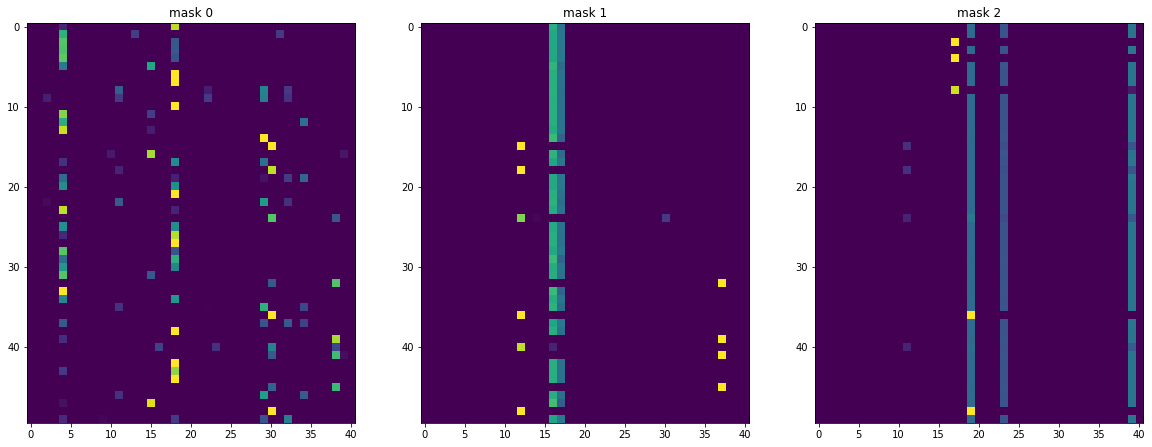

In [11]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")